In [1]:
%load_ext autoreload
%autoreload 2

# EO-LEARN PIPELINE

## Imports

In [ ]:
### Data manipulation ###
import pandas as pd
import numpy as np
import geopandas as gpd
from bs4 import BeautifulSoup
import rasterio
from shapely.geometry import Polygon

### Utils ###
from datetime import datetime
import os
import sys
from satellitecrops.utils.sql_connector import SQLConnection
import tqdm

### Data viz ###
import matplotlib.pyplot as plt

### EO-Learn / SentinelHub ###
from sentinelhub import UtmZoneSplitter, BBox, CRS
from eolearn.core import (
    EOPatch,
    EOExecutor,
    FeatureType,
    EOTask,
    SaveTask,
    OverwritePermission,
    EOWorkflow,
    linearly_connect_tasks
    )
from eolearn.io import SentinelHubInputTask, VectorImportTask
from eolearn.geometry import VectorToRasterTask


## Environnement variables

In [ ]:
# TODO : Use var env for region selection
REGION = "pays_basque" # ~zone
DATA_PATH = os.path.join(os.path.dirname(os.getcwd()), "data", "region", REGION)
EOPATCH_FOLDER = os.path.join(DATA_PATH, "eopatches")
EOPATCH_SAMPLES_FOLDER = os.path.join(DATA_PATH, "eopatches_sampled")
RESULTS_FOLDER = os.path.join(DATA_PATH, "results")
LOCAL_CRS = 32630

## Load local image and coordinates

In [ ]:
# Init data folders
for folder in (EOPATCH_FOLDER, EOPATCH_SAMPLES_FOLDER, RESULTS_FOLDER):
    os.makedirs(folder, exist_ok=True)

In [ ]:
# load zone coordinates
with open(os.path.join(DATA_PATH, "metadata.xml")) as fd:
    soup = BeautifulSoup(fd, "xml")
    zone_coordinate = soup.find("EXT_POS_LIST").text.split()
    zone_coordinate = np.array(zone_coordinate).reshape(
        int(len(zone_coordinate)/2), 2
    )
zone_coordinate

In [ ]:
from rasterio.plot import show

In [ ]:
# load image of the zone
with rasterio.open(os.path.join(DATA_PATH, "tci_img.jp2")) as fd:
    raster_img = fd.read(1)

In [ ]:
show(raster_img)

In [ ]:
# load covered zone of region
contour_path = os.path.join(DATA_PATH, "contour_zone.geojson")
zone_covered = gpd.read_file(contour_path).to_crs(LOCAL_CRS)
zone_covered

In [ ]:
zone_covered.bounds

## Divide region into boxes

### Parameters

In [ ]:
resolution = 10 # meters per pixel, used for raster dimension and satellite images
patch_dim = 255 # number of pixels

### Create a splitter to obtain a list of bboxes

In [ ]:
splitter = UtmZoneSplitter(
    zone_covered.geometry.values,
    LOCAL_CRS,
    patch_dim * resolution)
bbox_list = np.array(splitter.get_bbox_list())
info_list = np.array(splitter.get_info_list())

### Prepare info of selected EOPatches

In [ ]:
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list]

idxs = [info["index"] for info in info_list]
idxs_x = [info["index_x"] for info in info_list]
idxs_y = [info["index_y"] for info in info_list]

bbox_gdf = gpd.GeoDataFrame({
    "index": idxs,
    "index_x": idxs_x,
    "index_y": idxs_y}, crs=LOCAL_CRS, geometry=geometry)

### Save to shapefile

In [ ]:
shapefile_name = "grid_paysbasque_500x500.gpkg"
bbox_gdf.to_file(os.path.join(RESULTS_FOLDER, shapefile_name), driver="GPKG")

### Display boxes over covered region

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
zone_covered.plot(ax=ax, facecolor="w", edgecolor="b")
bbox_gdf.plot(ax=ax, facecolor="w", edgecolor="r", alpha=0.5)

## Create eopatches for covered region from sentinel image

In [ ]:
sentinel_img_gpd = gpd.GeoDataFrame({
    "geometry": [Polygon([[lon, lat] for lat, lon in zone_coordinate])]
}, crs="EPSG:4326").to_crs(LOCAL_CRS)
sentinel_img_gpd

In [ ]:
boundaries = sentinel_img_gpd.bounds.iloc[0].to_list()

In [ ]:
eopatches = EOPatch(bbox=BBox(bbox=boundaries, crs=CRS('32630')))

if raster_img.ndim == 3:
    eopatches.data_timeless['BANDS'] = raster_img
else:
    eopatches.data_timeless['BANDS'] = raster_img[..., np.newaxis]

### Get parcelles_datas from DB or file if exists

In [ ]:
parcelles_path = os.path.join(DATA_PATH, f"{REGION}_parcelles.geojson")

if not os.path.isfile(parcelles_path):
    conn = SQLConnection()
    parcelles_df = conn.get_parcelles_in_bbox(zone_covered.geometry, 2154)
    parcelles_df.to_file(parcelles_df, driver="GeoJSON") # save data to file
else:
    print("loading cache")
    parcelles_df = gpd.read_file(parcelles_path)
parcelles_df

### EO-Learn workflow

In [ ]:
vector_feature = FeatureType.VECTOR_TIMELESS, "RPG_REFERENCE"

vector_import_task = VectorImportTask(vector_feature, parcelles_path)

rasterization_task = VectorToRasterTask(
    vector_feature,
    (FeatureType.MASK_TIMELESS, "MASK"),
    values_column="code_group",
    raster_resolution=resolution,
    raster_dtype=np.uint8
)

save = SaveTask(EOPATCH_FOLDER, overwrite_permission=OverwritePermission.OVERWRITE_FEATURES)

In [ ]:
workflow_nodes = linearly_connect_tasks(
    vector_import_task, rasterization_task, save
)

workflow = EOWorkflow(workflow_nodes)

workflow.dependency_graph()

In [ ]:
parcelles_df["code_group"] = parcelles_df.code_group.astype("int64")
parcelles_df.to_file(parcelles_path)
parcelles_df.info()

In [ ]:
input_node = workflow_nodes[0]
save_node = workflow_nodes[-1]
exec_args = []

for idx, bbox in enumerate(bbox_list[np.arange(0, 10, 1)]):
    exec_args.append(
        {
            input_node: {"bbox": bbox},
            save_node: {"eopatch_folder": f"eopatch_{idx}"}
        }
    )

executor = EOExecutor(workflow, exec_args, save_logs=True)
executor.run(workers=4)
executor.make_report()

In [ ]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 25))

for i in tqdm(range(len(bbox_list[np.arange(0, 10, 1)]))):
    eopatch_path = os.path.join(EOPATCH_FOLDER, f"eopatch_{i}")
    eopatch = EOPatch.load(eopatch_path, lazy_loading=True)

    ax = axs[i // 5][i % 5]
    im = ax.imshow(eopatch.mask_timeless["RPG_colors_dict"].squeeze())
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axs.ravel().tolist(), orientation="horizontal", pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20)
# cb.set_ticks([entry.id for entry in LULC])
# cb.ax.set_xticklabels([entry.name for entry in LULC], rotation=45, fontsize=15)
plt.show();

In [ ]:
from satellitecrops.eolearn.pipeline import get_zone_to_patch
from satellitecrops.utils.bucket import BucketConnector
import geojson

bucket = BucketConnector()


In [ ]:
res = bucket.get_blob("contour_zone.geojson")
geo_data = geojson.loads(res)


In [ ]:
import geopandas as gpd

zone = gpd.GeoDataFrame(geometry=[geo_data["geometry"]], crs=4326)

In [ ]:
zone.to_crs(LOCAL_CRS)

In [ ]:
zone.geometry.values

In [ ]:
def add_data2subpatch(sat_patch, eopatch):
    # Find the pixel indices corresponding to the small_bbox
    height, width = sat_patch.data_timeless['BANDS'].shape[-2:]

    min_x, min_y = eopatch.bbox.lower_left
    max_x, max_y = eopatch.bbox.upper_right
    patch_min_x, patch_min_y = sat_patch.bbox.lower_left
    patch_max_x, patch_max_y = sat_patch.bbox.upper_right
    # compute coord of each pixel of sat_patch
    x_pxl_coord = np.linspace(patch_min_x, patch_max_x, width)
    y_pxl_coord = np.linspace(patch_min_y, patch_max_y, height)
    x_min_idx = np.searchsorted(x_pxl_coord, min_x)
    x_max_idx = np.searchsorted(x_pxl_coord, max_x)
    y_min_idx = np.searchsorted(y_pxl_coord, min_y)
    y_max_idx = np.searchsorted(y_pxl_coord, max_y)
    # Copy data features
    for feature_type, feature_name in sat_patch.get_features():
        if feature_type.is_spatial():
            eopatch[feature_type][feature_name] = sat_patch[feature_type][feature_name][:,height-y_max_idx:height-y_min_idx, x_min_idx:x_max_idx]
    return eopatch

In [ ]:
for eo_file in eopatches_files:
    eo_file_path = os.path.join(EOPATCH_FOLDER, eo_file)
    eopatch = EOPatch.load(eo_file_path, lazy_loading=True)
    add_data2subpatch(sat_patch, eopatch)
    eopatch.save(eo_file_path, overwrite_permission=OverwritePermission.OVERWRITE_FEATURES)


In [ ]:
eopatch_path = os.path.join(EOPATCH_FOLDER, f"eopatch_{1}")
eopatch = EOPatch.load(eopatch_path, lazy_loading=True)


In [ ]:
eopatch.bbox.lower_left, eopatch.bbox.upper_right

In [ ]:
src = rasterio.open("./out_image.jp2")

In [ ]:
src.bounds

In [ ]:
type(src.bounds)

In [ ]:
transform = src.transform
transform

In [ ]:
lower_left = eopatch.bbox.lower_left
upper_right = eopatch.bbox.upper_right

In [ ]:
from rasterio.windows import Window

In [ ]:
# Convert coordinates to pixel indices
col_start, row_stop = ~transform * lower_left
col_stop, row_start = ~transform * upper_right

# Ensure the indices are integers
col_start, row_stop = int(col_start), int(row_stop)
col_stop, row_start = int(col_stop), int(row_start)

# Calculate the width and height of the window
width = col_stop - col_start
height = row_stop - row_start

# Define the window
window = Window(col_start, row_start, width, height)

# Read the window
patch = src.read(window=window)

# Update the transform for the new window
new_transform = src.window_transform(window)

# Metadata for the output file
out_meta = src.meta.copy()
out_meta.update({
    "driver": "JP2",
    "height": height,
    "width": width,
    "transform": new_transform
})

# Save the patch to a new file
with rasterio.open("./new_out_eo_patch_img.jp2", "w", **out_meta) as dest:
    dest.write(patch)

In [ ]:
img = rasterio.open("./new_out_eo_patch_img.jp2")

In [ ]:
data = img.read(1)

In [ ]:
np.expand_dims(data, 0).shape

In [ ]:
plt.imshow(data)

In [ ]:
data = EOPatch.load("/home/adbla/code/adblanq/satellite-crops/data/departments/landes/eopatches/eopatch_0")

In [ ]:
data.mask_timeless["MASK"].shape

In [ ]:
data.data_timeless["BANDS"].shape

In [ ]:
plt.imshow(data.data_timeless["BANDS"].squeeze())


In [ ]:
gpd.GeoDataFrame.from_file("./../data/departments/landes/contour_zone.geojson").bounds

# Satellite crops pipeline

In [1]:
### Data manipulation ###
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup

### Utils ###
import os
import sys
### eolearn tools

import satellitecrops.eolearn.pipeline as pipeline
from satellitecrops.eolearn.eolearn_workflow import make_and_run_workflow
from satellitecrops.eolearn.create_eopatches import get_zone_to_patch, create_bbox_of_zone, get_parcelles_from_db, zone2sat_patch
from satellitecrops.eolearn.enrich_eopatches import add_sat_patch_to_eopatch, add_data_from_sat_patches_to_eopatches
from satellitecrops.utils.sql_connector import SQLConnection
from satellitecrops.params import *
from satellitecrops.utils.bucket import BucketConnector

from colorama import Fore, Style


In [2]:

pipeline.init_env()



⏳ Init environnement
✅ Environnement loaded


In [3]:
sat_dir_path = os.path.join(DATA_DIR_LOCAL, SAT_IMG_FOLDER, DPT_FOLDER, IMG_ORIGIN, IMG_LOC, YEAR, "1")
shots_list = os.listdir(sat_dir_path)

(3, 10980, 10980) (120560400, 10980, 1)
(3, 10980, 10980) (120560400, 10980, 1)
(3, 10980, 10980) (120560400, 10980, 1)
(3, 10980, 10980) (120560400, 10980, 1)
(3, 10980, 10980) (120560400, 10980, 1)
(3, 10980, 10980) (120560400, 10980, 1)
(3, 10980, 10980) (120560400, 10980, 1)
(3, 10980, 10980) (120560400, 10980, 1)
(3, 10980, 10980) (120560400, 10980, 1)
(3, 10980, 10980) (120560400, 10980, 1)
(3, 10980, 10980) (120560400, 10980, 1)
(3, 10980, 10980) (120560400, 10980, 1)
(3, 10980, 10980) (120560400, 10980, 1)
(3, 10980, 10980) (120560400, 10980, 1)
(3, 10980, 10980) (120560400, 10980, 1)
(3, 10980, 10980) (120560400, 10980, 1)
(3, 10980, 10980) (120560400, 10980, 1)
(3, 10980, 10980) (120560400, 10980, 1)
(3, 10980, 10980) (120560400, 10980, 1)
(3, 10980, 10980) (120560400, 10980, 1)
uint8


<Figure size 1000x1000 with 0 Axes>

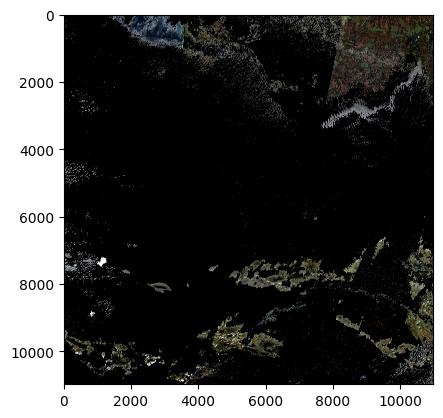

<Figure size 1000x1000 with 0 Axes>

In [20]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
num_shots = len(shots_list)
img_clean = np.zeros((1))
for i in range(num_shots):
    img_path = os.path.join(sat_dir_path, shots_list[i], 'TCI.tif')
    cld_path = os.path.join(sat_dir_path, shots_list[i], 'SCL.tif')
    if os.path.isfile(img_path) & os.path.isfile(cld_path):
        with rasterio.open(img_path) as img_file:
            with rasterio.open(cld_path) as cld_file:
                img = img_file.read()
                print(img.shape, img.strides)
                if img_clean.shape != img.shape:
                    img_clean = np.zeros(img.shape, dtype=np.uint8)
                cld = np.repeat(np.repeat(np.isin(cld_file.read(), [4, 5, 6, 7]), 2, axis=2), 2, axis=1)
                img_clean[img_clean==0]= (img*(np.repeat(cld, img.shape[0], axis=0)))[img_clean==0]
                print(img_clean.shape, img_clean.strides)
del img
del cld
print(img_clean.dtype)
plt.imshow(np.moveaxis(img_clean, 0, 2))
plt.figure(figsize=(10,10))

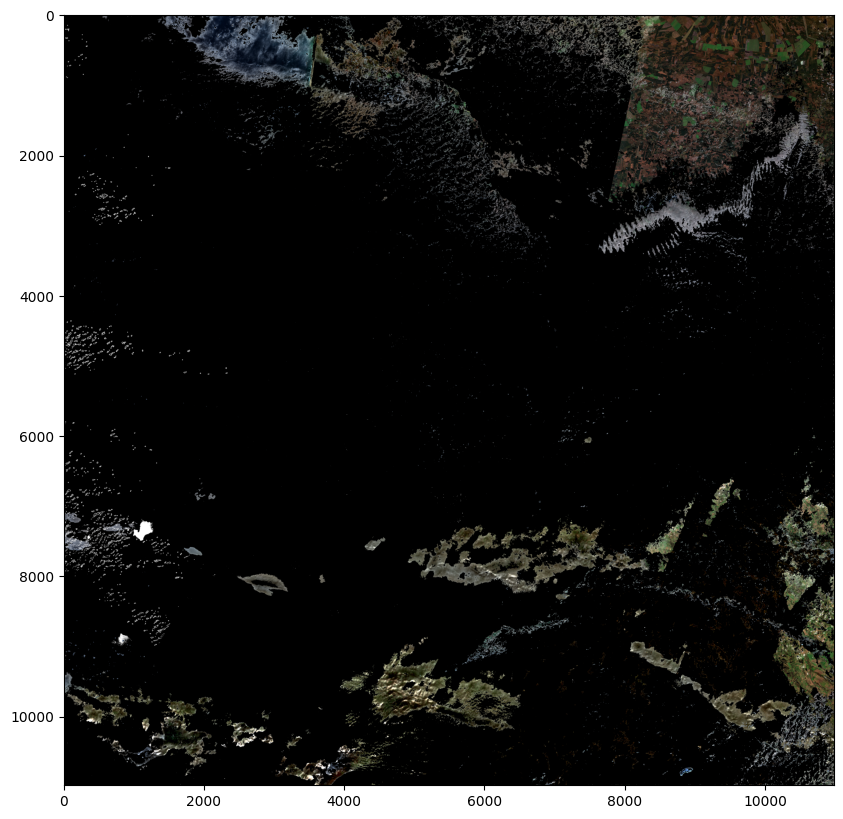

In [22]:
ax = plt.figure(figsize=(10,10))
plt.imshow(np.moveaxis(img_clean, 0, 2))


In [ ]:
print(Fore.MAGENTA + "\n⏳ Loading satellite image of the zone" + Style.RESET_ALL)
add_data_from_sat_patches_to_eopatches(os.listdir(EOPATCH_FOLDER), sat_dir_path)